# Cervical Cancer: Predicting Biopsy Results

Author: Christie Summers<br><br>
Email: cledeker@gmail.com<br><br>
Date: 2/18/2018

## Overview
In this analysis, machine learning techniques were used to build a predictive model for cervical cancer biopsy results based on cytology results and other potential risk factors, including demographics and patient history. The importance of various risk factors were explored. <br><br>The data set was obtained from UCI's Machine Learning Repository. Note that detailed descriptions of the attributes were not provided.

## 1. Data Description
The data set was downloaded from UC Irvine's Machine Learning Repository at the following website:<br>
https://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29
<br><br>Note that cytology results were included in the prediction model due to the fairly routine nature of Pap tests. Hinselmann and Schiller test results were not included in the prediction model. 
<br><br>The following information is provided on UCI's website:
<br><br>Data Set Information:
<br><br>The dataset was collected at 'Hospital Universitario de Caracas' in Caracas, Venezuela. The dataset comprises demographic information, habits, and historic medical records of 858 patients. Several patients decided not to answer some of the questions because of privacy concerns (missing values).<br><br>
Data Set Information:
- (bool) Biopsy: TARGET VARIABLE
- (bool) Hinselmann: test result (excluded from prediction model)
- (bool) Schiller: test result (excluded from prediction model)
- (bool) Cytology: test result (included in prediction model)
- (int) Age 
- (int) Number of sexual partners 
- (int) First sexual intercourse (age) 
- (int) Num of pregnancies 
- (bool) Smokes 
- (bool) Smokes (years) 
- (bool) Smokes (packs/year) 
- (bool) Hormonal Contraceptives 
- (int) Hormonal Contraceptives (years) 
- (bool) IUD 
- (int) IUD (years) 
- (bool) STDs 
- (int) STDs (number) 
- (bool) STDs:condylomatosis 
- (bool) STDs:cervical condylomatosis 
- (bool) STDs:vaginal condylomatosis 
- (bool) STDs:vulvo-perineal condylomatosis 
- (bool) STDs:syphilis 
- (bool) STDs:pelvic inflammatory disease 
- (bool) STDs:genital herpes 
- (bool) STDs:molluscum contagiosum 
- (bool) STDs:AIDS 
- (bool) STDs:HIV 
- (bool) STDs:Hepatitis B 
- (bool) STDs:HPV 
- (int) STDs: Number of diagnosis 
- (int) STDs: Time since first diagnosis 
- (int) STDs: Time since last diagnosis 
- (bool) Dx:Cancer 
- (bool) Dx:CIN 
- (bool) Dx:HPV 
- (bool) Dx 

## 2. Load Data and Overview 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, learning_curve, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from fancyimpute import KNN
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image
from scipy import stats
from scipy.stats import levene
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

%matplotlib inline
sns.set_style('white')

Using TensorFlow backend.


In [2]:
df = pd.read_csv('risk_factors_cervical_cancer.csv')

print("\n************ Data Set Overview *************")
print("Data contains %i observations & %i columns. " %df.shape)
print("The total number of missing values are %i." %df.isnull().sum().sum())


************ Data Set Overview *************
Data contains 858 observations & 36 columns. 
The total number of missing values are 0.


In [3]:
# Check first few rows. Note that the data set contains missing values marked as "?".
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


## 3. Preprocessing

### Replace Missing Values and Drop Unneeded Columns

In [4]:
# Replace question marks with missing values.
cols = df.columns

for col in cols:
    if type(df[col][0])==str:
        df[col] = df[col].replace({'?': np.nan})

Text(0.5,1,'Missing Values')

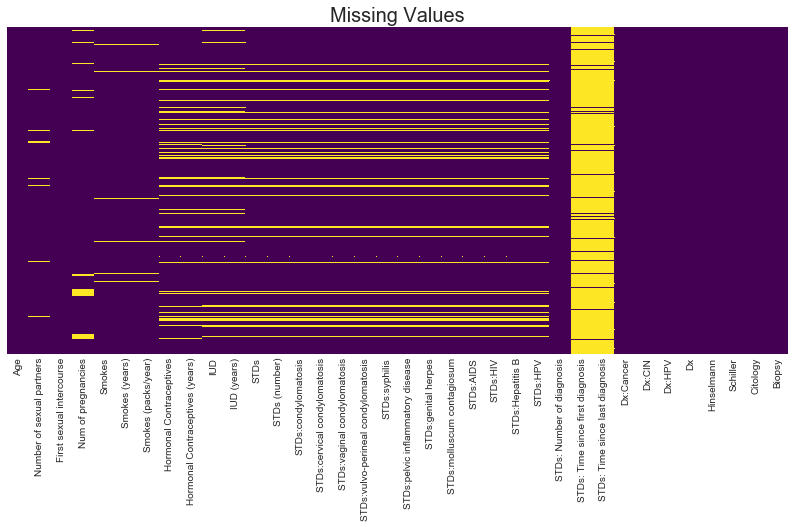

In [5]:
# Look at missing data.
plt.figure(figsize=(14,6))
p = sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
p.axes.set_title("Missing Values",fontsize=20)

#### Two features contain mostly missing values, and these features will therefore be dropped.

In [6]:
# Remove both columns with large number of missing values.
df.drop(['STDs: Time since first diagnosis','STDs: Time since last diagnosis'],axis=1,inplace=True)

In [7]:
# Check number of missing values for each of the remaining features. 
print('Number of missing values:')
df.isnull().sum()

Number of missing values:


Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105
STDs:Hepatitis B                  

#### Note that data collected on hormonal contraceptives, STDs, and IUDs have a lot of missing values.

Text(0.5,1,"Binary Features: Visualizing the 1's (remaining values are 0 or missing)")

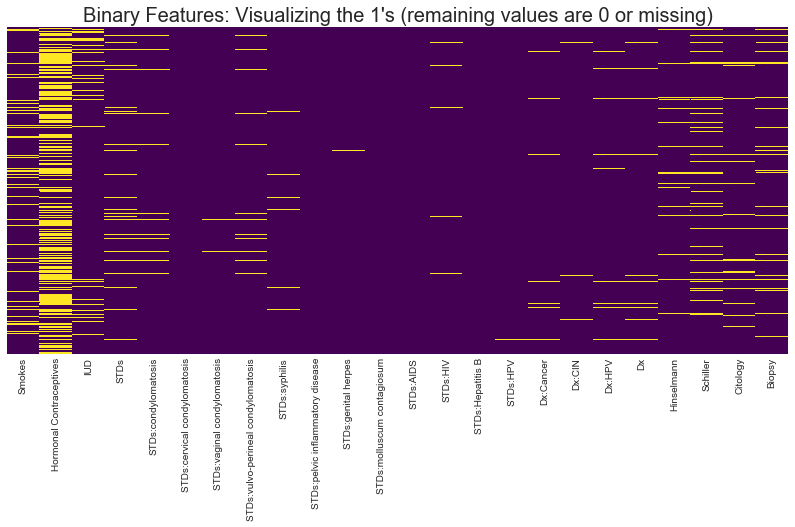

In [8]:
# Separate binary features from integer features, and plot the 1's within each binary feature.

# Identify features that are integers.
int_cols = ['Age', 
            'Number of sexual partners', 
            'First sexual intercourse', 
            'Num of pregnancies',
            'Hormonal Contraceptives (years)', 
            'IUD (years)',
            'STDs (number)',
            'STDs: Number of diagnosis',
            'Smokes (years)',
            'Smokes (packs/year)'
           ]

# Get all data for binary features and convert to float.
df_bin = df.drop(int_cols,axis=1)
for col in df_bin.columns:
    df_bin[col] = df_bin[col].apply(lambda x: float(x))

# Plot the 1's in the binary data.
plt.figure(figsize=(14,6))
p = sns.heatmap(df_bin == 1,yticklabels=False,cbar=False,cmap='viridis')
p.axes.set_title("Binary Features: Visualizing the 1's (remaining values are 0 or missing)",fontsize=20)

#### Most of the binary features contain mostly values of 0. Some of the features appear to not contain any 1's. Features with 2 or fewer 1's will be dropped.

In [9]:
# Drop binary features with 2 or fewer 1's.
del_lst = []
flag_lst = []
for col in df_bin.columns:
    if df_bin[df_bin[col]==1][col].count() <= 2:
        del_lst.append(col)
        
df_bin.drop(del_lst,axis=1,inplace=True)

In [10]:
# Impute missing values using KNN imputation (standardize integer data first).

# Standardize integer data.
df_int = df[int_cols]
int_lst = []
col_means = []
col_stds = []

for col in int_cols:
    df_fl = df_int[col].apply(lambda x: float(x))
    col_mean = df_fl.mean()
    col_std = df_fl.std()
    col_means.append(col_mean)
    col_stds.append(col_std)
    int_lst.append(df_int[col].apply(lambda x: (float(x) - col_mean)/col_std))

df_scaled = pd.DataFrame(int_lst).transpose()

# Combine binary and integer (scaled) data sets.
df_bin_int = pd.concat([df_scaled,df_bin],axis=1)

# Use KNN to impute missing values (k=3).
df_imputed = KNN(k=3).complete(df_bin_int)
df_imputed = pd.DataFrame(df_imputed)
df_imputed.columns = df_bin_int.columns

# Convert imputed values for binary variables to 0's and 1's (1 for imputed values >= 0.5).
for col in df_bin.columns:
    df_imputed[col] = df_imputed[col].apply(lambda x: 1 if x >= 0.5 else 0)

# Convert integer data back to original state (unstandardized) to improve interpretability of results.
for i in range(len(int_cols)):
    df_imputed.iloc[:,i] = df_imputed.iloc[:,i].apply(lambda x: x*col_stds[i] + col_means[i])

Imputing row 1/858 with 0 missing, elapsed time: 0.183
Imputing row 101/858 with 0 missing, elapsed time: 0.185
Imputing row 201/858 with 0 missing, elapsed time: 0.189
Imputing row 301/858 with 0 missing, elapsed time: 0.192
Imputing row 401/858 with 0 missing, elapsed time: 0.195
Imputing row 501/858 with 0 missing, elapsed time: 0.198
Imputing row 601/858 with 0 missing, elapsed time: 0.201
Imputing row 701/858 with 12 missing, elapsed time: 0.202
Imputing row 801/858 with 0 missing, elapsed time: 0.206


## 4. Exploratory Data Analysis

### Overview of Target 

In [11]:
print('\n%i individuals had negative biopsy results' %df_imputed['Biopsy'].value_counts()[0])
print('& %i individuals had positive biopsy results.' %df_imputed['Biopsy'].value_counts()[1])


803 individuals had negative biopsy results
& 55 individuals had positive biopsy results.


#### There are many more individuals in the negative biopsy group, and this imbalance in categories presents some challenges for predictive modelling. The F1 score will therefore be used as criteria for model evaluation in order to balance recall and precision. 

### Integer Features

In [12]:
# Identify age groupings for individuals. 
age_groups = []
for i in range(len(df_imputed)):
    if df_imputed['Age'].iloc[i] >= 50:
        age_groups.append('Group 5: 50+')
    elif df_imputed['Age'].iloc[i] < 50 and df_imputed['Age'].iloc[i] >= 40:
        age_groups.append('Group 4: 40-50')
    elif df_imputed['Age'].iloc[i] < 40 and df_imputed['Age'].iloc[i] >= 30:
        age_groups.append('Group 3: 30-40')
    elif df_imputed['Age'].iloc[i] < 30 and df_imputed['Age'].iloc[i] >= 20:
        age_groups.append('Group 2: 20-30')
    elif df_imputed['Age'].iloc[i] < 20:
        age_groups.append('Group 1: Under 20')
    else:
        age_groups.append('None')

In [13]:
# Identify Hormonal Contraceptives (years) groupings for individuals. 
h_contr = df_imputed['Hormonal Contraceptives (years)']
contr_grp = []
for i in range(len(h_contr)):
    if h_contr.iloc[i] == 0:
        contr_grp.append('Group 1: None')
    elif h_contr.iloc[i] < 2 and h_contr.iloc[i] > 0:
        contr_grp.append('Group 2: Up to 2')
    elif h_contr.iloc[i] < 4 and h_contr.iloc[i] >= 2:
        contr_grp.append('Group 3: 2-4')
    elif h_contr.iloc[i] < 6 and h_contr.iloc[i] >= 4:
        contr_grp.append('Group 4: 4-6')
    elif h_contr.iloc[i] >= 6:
        contr_grp.append('Group 5: 6+')
    else:
        contr_grp.append('Missing')

In [14]:
# Concatenate Hormonal Contraceptive and Age groupings, along with Biopsy results into one dataframe.
one = pd.DataFrame(contr_grp)
two = pd.DataFrame(age_groups)
three= pd.DataFrame(df_imputed['Biopsy']).reset_index(drop=True)
df_piv = pd.concat([one,two,three],axis=1)
df_piv.columns = ['Hormonal Contraceptives (years)','Age','Biopsy']

Median Hormonal Contraceptives (Years) by Biopsy Group:
        Hormonal Contraceptives (years)
Biopsy                                 
0                                   0.5
1                                   0.5

Mean Hormonal Contraceptives (Years) by Biopsy Group:
        Hormonal Contraceptives (years)
Biopsy                                 
0                              2.126563
1                              3.318000


Heatmap Showing Percent with Positive Biopsy Results by Age & Hormonal Contraceptive Grouping


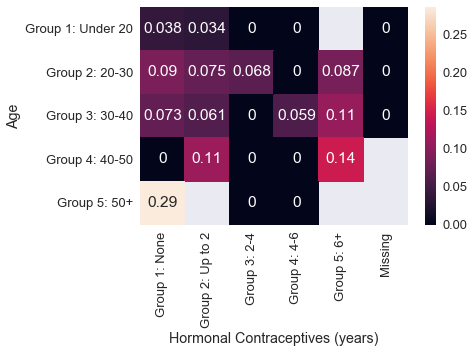

In [52]:
# Check relationship between Hormonal Contraceptives (years) and biopsy results.

# Show average years by biopsy results.
hc = df_imputed['Hormonal Contraceptives (years)']
print('Median Hormonal Contraceptives (Years) by Biopsy Group:')
print(pd.DataFrame({'Biopsy': df_imputed['Biopsy'], 'Hormonal Contraceptives (years)': hc}).groupby('Biopsy').median())

print('\nMean Hormonal Contraceptives (Years) by Biopsy Group:')
print(pd.DataFrame({'Biopsy': df_imputed['Biopsy'], 'Hormonal Contraceptives (years)': hc}).groupby('Biopsy').mean())

# Create a pivot table and plot a heatmap with Hormonal Contraceptive and Age groupings.
pvcontr = df_piv.pivot_table(values='Biopsy',index='Age',columns='Hormonal Contraceptives (years)')
print('\n\nHeatmap Showing Percent with Positive Biopsy Results by Age & Hormonal Contraceptive Grouping')
sns.set(font_scale=1.3)
sns.heatmap(pvcontr, annot=True)

#### The matrix plot shows that individuals who took hormonal contraceptives for 6 or more years and who were in the 30 to 50 age groups had some of the highest percentages of positive biopsy results. Although the percentage of people with positive biopsy results in the 50+ age group who did not take hormonal contraceptives was high, note that there were only 7 individuals in this grouping (see counts below).

#### The median years that an individual took hormonal contraceptives did not differ based on biopsy results; however, the average number of years was slightly higher for those in the positive biopsy group, suggesting that hormonal contraceptives have a highly right-skewed distribution. 

In [16]:
# Get counts within each grouping for age and hormonal contraceptives.
df_cnts = df_piv.groupby(['Age','Hormonal Contraceptives (years)']).count()
df_cnts.columns = ['Count']
df_cnts

Count
Age               Hormonal Contraceptives (years)       
Group 1: Under 20 Group 1: None                       78
                  Group 2: Up to 2                    87
                  Group 3: 2-4                         9
                  Group 4: 4-6                         3
                  Missing                              2
Group 2: 20-30    Group 1: None                      111
                  Group 2: Up to 2                   134
                  Group 3: 2-4                        59
                  Group 4: 4-6                        40
                  Group 5: 6+                         46
                  Missing                              4
Group 3: 30-40    Group 1: None                       55
                  Group 2: Up to 2                    66
                  Group 3: 2-4                        25
                  Group 4: 4-6                        17
                  Group 5: 6+                         56
                  Missing                              1
Group 4: 40-50    Group 1: None                       18
                  Group 2: Up to 2                     9
                  Group 3: 2-4                         4
                  Group 4: 4-6                         4
                  Group 5: 6+                         21
Group 5: 50+      Group 1: None                        7
                  Group 3: 2-4                         1
                  Group 4: 4-6                         1


Average Age by Biopsy Group:
              Age
Biopsy           
0       26.696139
1       28.636364


Text(0,0.5,'Age')

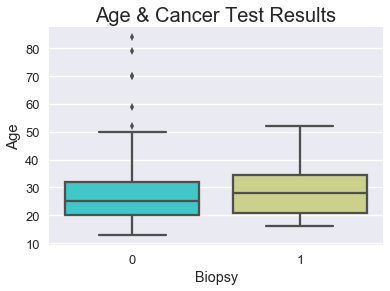

In [65]:
# Plot age & cancer test results. 
print('\nAverage Age by Biopsy Group:')
print(pd.DataFrame({'Biopsy': df_imputed['Biopsy'], 'Age': df_imputed['Age']}).groupby('Biopsy').mean())

sns.set_context('talk',font_scale=1)
b = sns.boxplot(x="Biopsy", y="Age", data=df_imputed,palette='rainbow')
b.axes.set_title("Age & Cancer Test Results",fontsize=20)
b.set_ylabel("Age",fontsize=15)

#### Median age was slightly higher for those with positive test results. Let's check for significant differences, but let's first check assumptions for the t-test.

In [46]:
# The assumption of normality seems reasonable based on the boxplot above. Double the assumption 
# of equal variances using a Brown Forsythe Levene test.
biop_age = df_imputed[['Biopsy','Age']]
biop_pos_age = biop_age[biop_age['Biopsy']==1]['Age']
biop_neg_age = biop_age[biop_age['Biopsy']==0]['Age']
levene(biop_pos_age, biop_neg_age)

LeveneResult(statistic=0.48542250246258428, pvalue=0.48616551062289826)

#### Assumptions of normality and equal variances seem reasonable (p-value for the null hypothesis of equal variances was 0.49). A t-test will therefore be used to test for significant differences in age based on biopsy results.

In [48]:
# t-test for significant differences in age based on biopsy results.
ttest_ind(biop_pos_age,biop_neg_age)

Ttest_indResult(statistic=1.6396861910271414, pvalue=0.10143784847300615)

#### There was not a significant difference in age based on biopsy results at the 95% confidence level (p-value=0.10).

### Binary Features

In [19]:
# Show a sorted list of the following for each binary feature:
# % individuals with feature & cancer divided by the total number of individuals with cancer

# Get binary columns and create a list of binary columns (excluding the target variable).
df_bin = df_imputed.drop(int_cols,axis=1)
cols = df_bin.drop(['Biopsy'],axis=1).columns

# Create empty lists.
c_and_col = []
w_feat = []
cnt = []

# Compute the number of individuals who have both cancer and the given feature as a 
# percent out of the total number of inidividuals with cancer.
for col in cols:
    df_col = df_bin[col]
    df_col = pd.concat([df_col,df_bin['Biopsy']],axis=1)
    yy = df_col[(df_col[col]==1) & (df_col['Biopsy']==1)]['Biopsy'].count()
    ny = df_col[(df_col[col]==0) & (df_col['Biopsy']==1)]['Biopsy'].count()
    yn = df_col[(df_col[col]==1) & (df_col['Biopsy']==0)]['Biopsy'].count()
    nn = df_col[(df_col[col]==0) & (df_col['Biopsy']==0)]['Biopsy'].count()
    c_and_col.append((100*(yy/(yy+ny))).round(2))
    w_feat.append((100*((yy+yn)/(yy+ny+nn+yn))).round(2))
    cnt.append(yy+yn)

# Concatenate dataframes.
bin_perc = pd.concat([pd.DataFrame(cols),pd.DataFrame(c_and_col),pd.DataFrame(w_feat),
                      pd.DataFrame(cnt)],axis=1)
bin_perc.columns = ['Feature','% w/ Cancer who have Feature','% of All Indiv. w/ Feature','Number with Feature']

print('\nThe following table shows:')
print(' % individuals with feature & cancer divided by the total number of individuals with cancer')
print(' % individuals with feature divided by the total number of individuals')
bin_perc = bin_perc.sort_values(by=['% w/ Cancer who have Feature'], ascending=False)
bin_perc.reset_index(drop=True)


The following table shows:
 % individuals with feature & cancer divided by the total number of individuals with cancer
 % individuals with feature divided by the total number of individuals


,Feature,% w/ Cancer who have Feature,% of All Indiv. w/ Feature,Number with Feature
0,Schiller,87.27,8.62,74
1,Hormonal Contraceptives,65.45,62.82,539
2,Hinselmann,45.45,4.08,35
3,Citology,32.73,5.13,44
4,STDs,21.82,9.32,80
5,Smokes,18.18,14.45,124
6,IUD,16.36,10.02,86
7,STDs:condylomatosis,12.73,5.13,44
8,STDs:vulvo-perineal condylomatosis,12.73,5.01,43
9,Dx,12.73,2.80,24


#### In the list above, large gaps between the two percentages shown may suggest that a given feature is related to the outcome of the biopsy test results. 
- The Schiller test showed the strongest relationship with biopsy results; 87% of the individuals with positive biopsy results also had positive results on the Schiller test. The Hinselmann test and cytology showed a weaker relationship with biopsy results; 45% of those who had positive biopsy results also had positive Hinselmann results, and only 33% of those with positive biopsy results also had positive cytology results. 
- The list above also suggests that STDs may be related to biopsy results. Approximately 22% of individuals with positive biopsy results also had an STD in the past, whereas only 9% of the total people surveyed had an STD in the past.

## 5. Predictive Model
A model was built to predict biopsy results using cytology results and other potential risk factors. Cytology results were included in the predictive models due to the fairly routine nature of this test. Hinselmann and Schiller results were not included.

The exploratory analysis above shows that if we had a model that predicted biopsy results based only on cytology results, we would have predicted approximately 33% of the positive biopsy results correctly. The goal with the predictive model is to improve our chances of accurately predicting biopsy results and to understand which risk factors have the biggest impact within the model.

### Train Test Split

In [20]:
# Remove Hinselmann and Schiller test results (keep cytology results).
df_imputed.drop(['Schiller','Hinselmann'],axis=1,inplace=True)

# Train test split, setting aside 20% of the data for testing the model.
X = df_imputed.drop('Biopsy',axis=1)
y = df_imputed['Biopsy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

### Initial Model and Feature Importances

In [21]:
# Fit a Decision Tree and evaluate performance via K-Fold Validation (k=10).

# Set fold to be used for all models.
kfold = 10

# Decision Tree.
dtc = DecisionTreeClassifier()
dtc_5_scores = cross_val_score(dtc, X_train, y_train, cv=kfold, scoring ='f1')
print("\nINITIAL MODEL (Decision Tree): ")
print("\nF1 Scores by Fold: ", dtc_5_scores)
print("F1 Mean:      %.4f" %dtc_5_scores.mean())
print("F1 Std. Dev.: %.4f" %dtc_5_scores.std())


INITIAL MODEL (Decision Tree): 

F1 Scores by Fold:  [ 0.2         0.26666667  0.4         0.4         0.          0.          0.
  0.5         0.44444444  0.25      ]
F1 Mean:      0.2461
F1 Std. Dev.: 0.1831



Feature Importances for Initial Model:


Text(0,0.5,'Features')

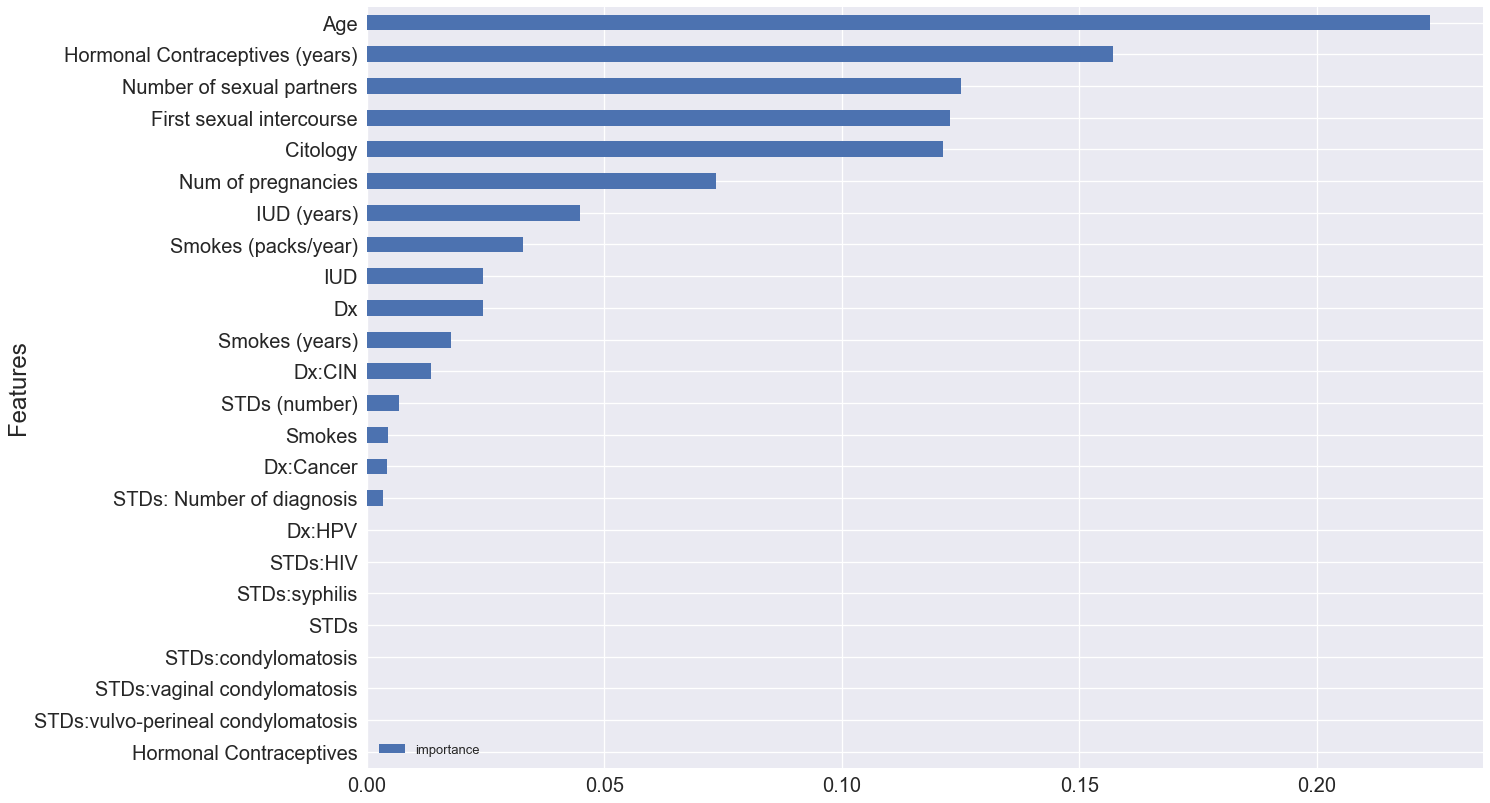

In [22]:
#Look at feature importances.
dtc.fit(X_train,y_train)
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = dtc.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

#Plot.
print("\nFeature Importances for Initial Model:")
ax = features.plot(kind='barh', figsize=(20, 14), fontsize=20)
ax.set_ylabel("Features", fontname="Arial", fontsize=24)

### Initial Comparison of Algorithms
Random Forest and Decision Tree algorithms were selected for comparison because this data set consists of many binary features, and these algorithms have minimal assumptions for the distribution of features.

In [23]:
from sklearn.model_selection import StratifiedKFold

C:\Users\clede\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\clede\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\clede\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\clede\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


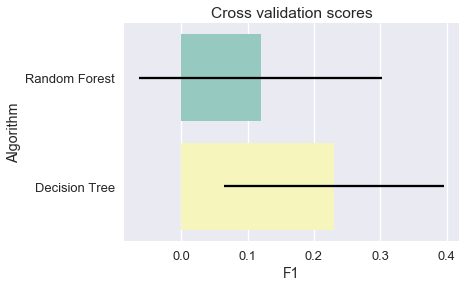

In [24]:
# Plot F1 scores for Random Forest and Decision Tree Classifiers. 

random_state = 2

# Define classifiers.
classifiers = []
classifiers.append(RandomForestClassifier(random_state=random_state, n_estimators=100))
classifiers.append(DecisionTreeClassifier(random_state=random_state))

# Get F1 scores.
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "f1", cv = kfold))

cv_means = []
cv_std = []

# Get means and standard deviations for F1 scores.
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

# Create dataframe.
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValStd": cv_std,"Algorithm":["Random Forest","Decision Tree"]})

# Plot.
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("F1")
g = g.set_title("Cross validation scores")

### Hyperparameter Tuning

In [25]:
# Random Forest hyperparameter tuning. 
RFC = RandomForestClassifier()

# Define parameter grid.
rf_param_grid = {"max_depth": [4, 6, 8, 10],
                 "max_features": ["sqrt", "log2", 2, 5, 10],
                 "min_samples_split": [3, 5, 10],
                 "min_samples_leaf": [3, 4, 5, 10],
                 "bootstrap": [False, True],
                 "n_estimators" :[100, 300],
                 "criterion": ["gini", "entropy"],
                 "class_weight": [None, 'balanced']
                }
                
# Search grid and store best estimator.
gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="f1", n_jobs= 4)
gsRFC.fit(X_train,y_train)
RFC_best = gsRFC.best_estimator_

# Print best score.
print('Best score: {}'.format(gsRFC.best_score_))
print('Best parameters: {}'.format(gsRFC.best_params_))

Best score: 0.4070711277708363
Best parameters: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 300}


In [26]:
# Decision Tree hyperparameter tuning.
DTC = DecisionTreeClassifier()

# Define parameter grid.
dt_param_grid = {"max_depth": [4, 6, 8, 10],
                 "max_features": ["sqrt", "log2", 17, 18, 19, 21],
                 "min_samples_split": [2, 3, 5, 10],
                 "min_samples_leaf": [3, 4, 5, 10],
                 "criterion": ["gini", "entropy"],
                 "class_weight": [None, 'balanced']
                }

# Search grid and store best estimator.
gsDTC = GridSearchCV(DTC,param_grid = dt_param_grid, cv=kfold, scoring="f1", n_jobs= 4)
gsDTC.fit(X_train,y_train)
DTC_best = gsDTC.best_estimator_

# Print best score.
print('Best score: {}'.format(gsDTC.best_score_))
print('Best parameters: {}'.format(gsDTC.best_params_))

Best score: 0.3492063492063492
Best parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'max_features': 19, 'min_samples_leaf': 4, 'min_samples_split': 3}


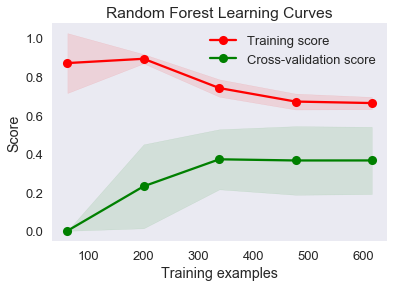

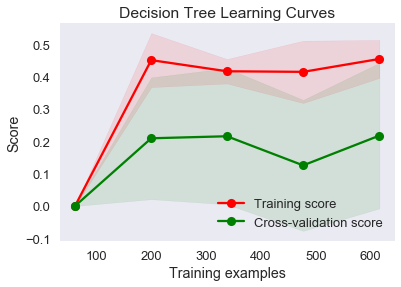

In [27]:
# Plot learning curves.
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a plot of the test and cross-validation learning curves using F1 as scoring metric."""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(RFC_best,"Random Forest Learning Curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(DTC_best,"Decision Tree Learning Curves",X_train,y_train,cv=kfold)

#### The Decision Tree shows a very large standard deviations in F1 scores across the learning curve. This issue in combination with the fact that it had lower F1 scores than the Random Forest model suggests that Random Forest is the better model. The learning curves show a relatively large gap in F1 scores between the training and cross-validation scores, which suggests that there may be an issue with high variance. F1 cross-validation scores tend to plateau after 300 samples are added to the model, which may suggest that looking at different features may help improve the model more than gathering additional data. 

### Best Model
The Random Forest model with optimized hyperparameters was selected as the best model based on the F1 score (F1 score for Random Forest was 0.42 versus 0.36 for the Decision Tree).


Feature Importances for Best Model:


Text(0,0.5,'Features')

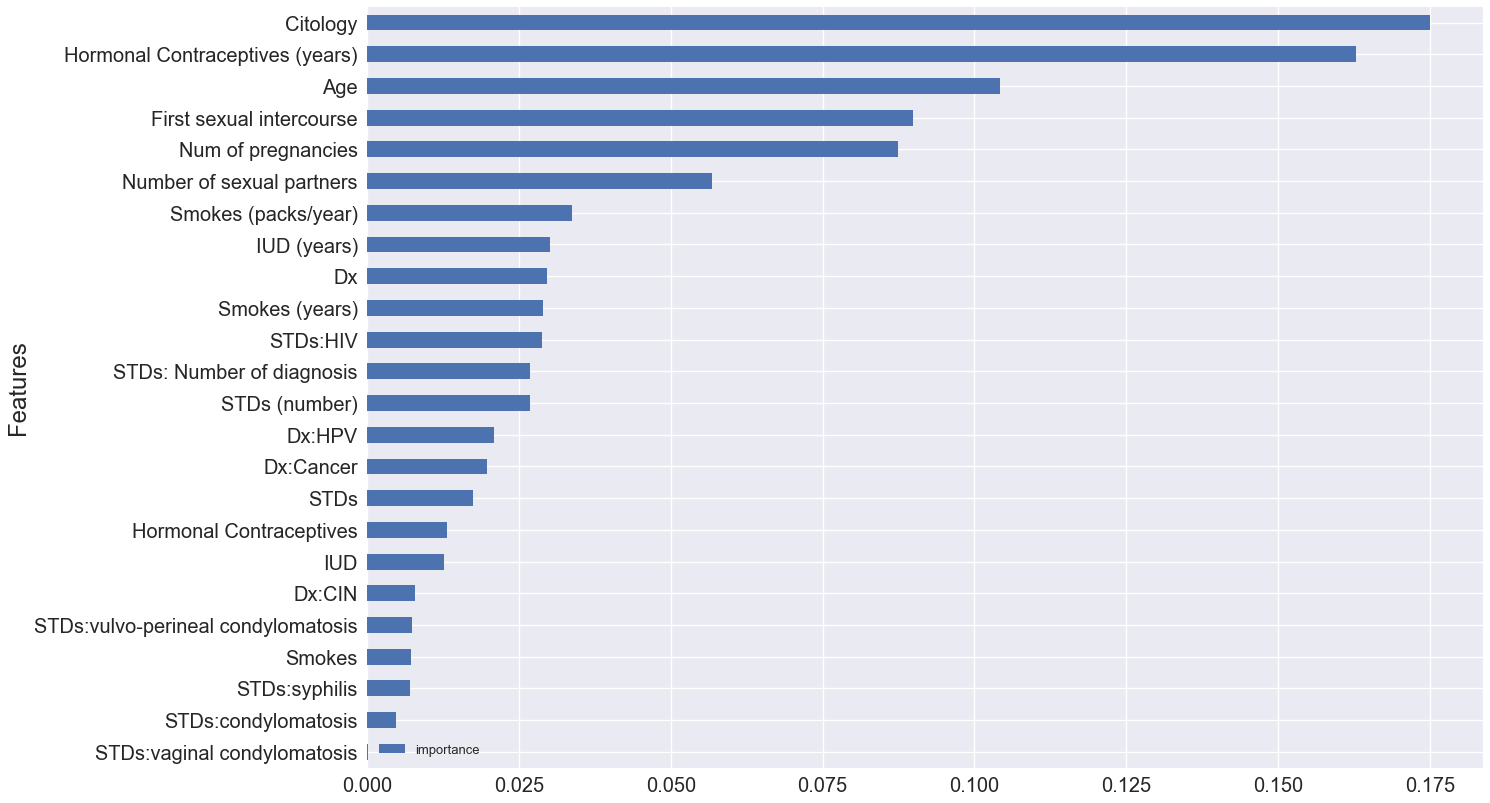

In [28]:
#Look at feature importances for best model.
RFC_best.fit(X_train,y_train)
features_best = pd.DataFrame()
features_best['feature'] = X_train.columns
features_best['importance'] = RFC_best.feature_importances_
features_best.sort_values(by=['importance'], ascending=True, inplace=True)
features_best.set_index('feature', inplace=True)

#Plot.
print("\nFeature Importances for Best Model:")
ax = features_best.plot(kind='barh', figsize=(20, 14), fontsize=20)
ax.set_ylabel("Features", fontname="Arial", fontsize=24)

#### Features with highest importances in this model are Cytology and Hormonal Contraceptives (Years), followed by Age of First Sexual Intercourse, Age, and Number of Pregnancies. 

In [29]:
# Print Classification Report for both training and test data.
test_predictions = RFC_best.predict(X_test)
train_predictions = RFC_best.predict(X_train)
print('\n***Training Data***')
print('\nClassification Report:')
print(classification_report(y_train, train_predictions))
print('\n***Test Data***')
print('\nClassification Report:')
print(classification_report(y_test, test_predictions))


***Training Data***

Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.97      0.98       644
          1       0.61      0.67      0.64        42

avg / total       0.96      0.95      0.95       686


***Test Data***

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.98      0.96       159
          1       0.57      0.31      0.40        13

avg / total       0.92      0.93      0.92       172



#### The Random Forest model selected performed similarly on the test and training data based on precision; however, recall and F1 scores were much lower for the test data compared to the training data. Scores for predicting negative biopsy results were much better than those for predicting positive biopsy results, which is to be expected given that positive biopsy results are a rare occurence.

Text(0.5,13,'Predicted label')

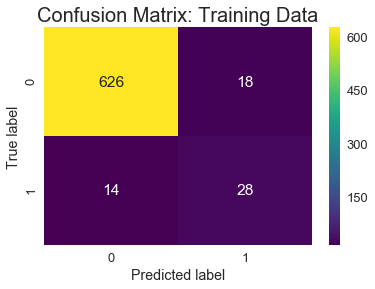

In [30]:
# Plot confusion matrix for training data.
cm = confusion_matrix(y_train, train_predictions)
sns.set(font_scale=1.3)
g = sns.heatmap(cm, annot=True, cmap='viridis', fmt='g')
g.axes.set_title("Confusion Matrix: Training Data",fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')

Text(0.5,13,'Predicted label')

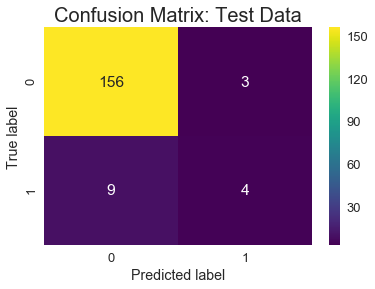

In [31]:
# Plot confusion matrix for test data.
cm = confusion_matrix(y_test, test_predictions)
sns.set(font_scale=1.3)
g = sns.heatmap(cm, annot=True, cmap='viridis', fmt='g')
g.axes.set_title("Confusion Matrix: Test Data",fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Decision Tree Splits

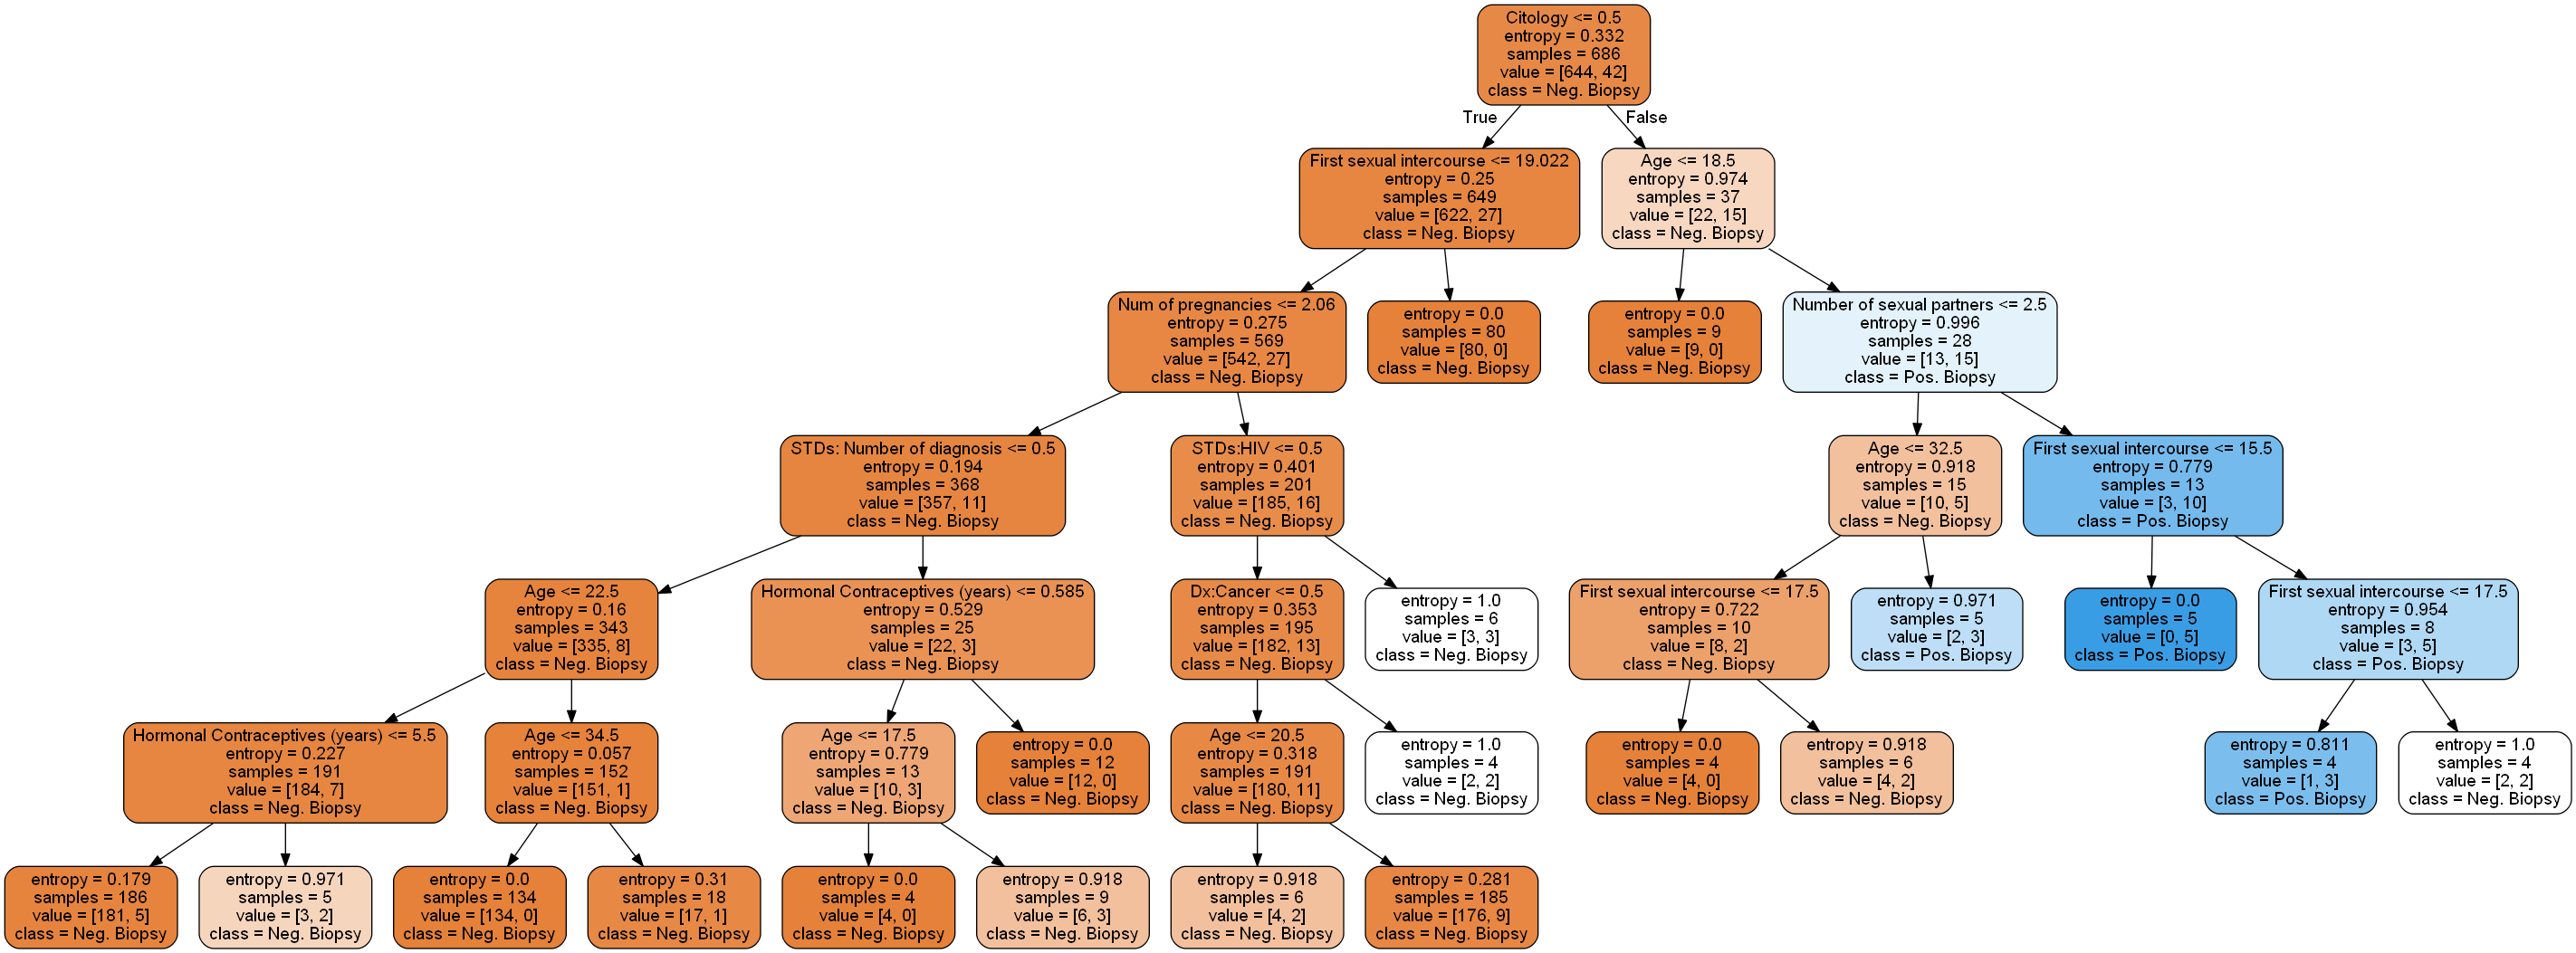

In [32]:
# Display the Decision Tree from the best Decision Tree model.
features = X_train.columns
classes = ['Neg. Biopsy', 'Pos. Biopsy']
dot_data = export_graphviz(DTC_best, filled=True, rounded=True, class_names=classes, 
                           feature_names = features, out_file=None)
graph_png = graph_from_dot_data(dot_data)
Image(graph_png.create_png())  

#### The Decision Tree shown above demonstrates how the model split individuals for predictions. Note that this model is not the same as the selected Random Forest model, which cannot be fully visualized, and the attribute importances likely differ between the models.
- The Decision Tree first splits on cytology results, indicating that positive cytology results was the most important predictor for positive biopsy results in this model. The next split is on age; individuals over 18 were more likely to have positive biopsy predictions. It then splits on number of sexual partners, grouping those with more sexual partners as higher risk for having positive biopsy results.
- Looking at the other features that were important in the Random Forest model sheds some additional light on the impact of these features. All of the individuals who had negative cytology results and who were older than 19 upon first sexual intercourse were predicted to have negative biopsy results. Individuals who had fewer pregnancies were more likely to be predicted to have negative biopsy results. The impact of hormonal contraceptives is unclear based on this model.

## 6. Conclusions
- A model was built to predict biopsy results for cervical cancer based on cytology results and various risk factors, including demographics and patient history. The Random Forest model selected had precision of 0.57, recall of 0.31, and an F1-score of 0.40 based on the test data. If we had a model that predicted biopsy results based only on cytology results, we would have predicted approximately 33% of the positive biopsy results correctly. The Random Forest model shows an improvement over this; it has predicted 57% of the positive biopsy results correctly (based on test precision). 
- The features with highest importances in the model were cytology results and the number of years that an individual took hormonal contraceptives, followed by age of first sexual intercourse, age, and number of pregnancies. 
- Exploratory data analysis and the snapshot of the best fit Decision Tree suggest that having positive cytology results, being an older patient, and factors such as having more sexual partners, having more pregnancies, and having sexual intercourse at an earlier age may increase someone's likelihood to have positive biopsy results. Although the impact of hormonal contraceptives was unclear from the Decision Tree, exploratory data analysis showed a slighlty higher percentage of positive biopsy results for older women who had taken hormonal contraceptives for 6 or more years. 

## 7. References
UCI's Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29<br>
Cancer.gov Website: https://www.cancer.gov/types/cervical/pap-hpv-testing-fact-sheet#q3